Для исследования возьмем задачу по определению рыночной стоимости автомобиля. Набор данных Car Price Prediction Challenge взят с Kaggle: https://www.kaggle.com/datasets/deepcontractor/car-price-prediction-challenge/code.

# Импортирование библиотек

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import plotly.express as px

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Загрузка набора данных Car Price Prediction 

In [ ]:
cars = pd.read_csv('/content/drive/MyDrive/Colab_Notebook_Julia/car_price_prediction.csv')

In [ ]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  object 
 1   Price             19227 non-null  float64
 2   Levy              19227 non-null  object 
 3   Manufacturer      19227 non-null  object 
 4   Model             19227 non-null  object 
 5   Prod. year        19227 non-null  float64
 6   Category          19227 non-null  object 
 7   Leather interior  19227 non-null  object 
 8   Fuel type         19227 non-null  object 
 9   Engine volume     19227 non-null  object 
 10  Mileage           19227 non-null  object 
 11  Cylinders         19227 non-null  float64
 12  Gear box type     19227 non-null  object 
 13  Drive wheels      19227 non-null  object 
 14  Doors             19227 non-null  object 
 15  Wheel             19227 non-null  object 
 16  Color             19227 non-null  object

In [ ]:
cars.head()

ID    Price  Levy Manufacturer    Model  Prod. year   Category  \
0  45654403  13328.0  1399        LEXUS   RX 450      2010.0       Jeep   
1  44731507  16621.0  1018    CHEVROLET  Equinox      2011.0       Jeep   
2  45774419   8467.0     -        HONDA      FIT      2006.0  Hatchback   
3  45769185   3607.0   862         FORD   Escape      2011.0       Jeep   
4  45809263  11726.0   446        HONDA      FIT      2014.0  Hatchback   

  Leather interior Fuel type Engine volume    Mileage  Cylinders  \
0              Yes    Hybrid           3.5  186005 km        6.0   
1               No    Petrol             3  192000 km        6.0   
2               No    Petrol           1.3  200000 km        4.0   
3              Yes    Hybrid           2.5  168966 km        4.0   
4              Yes    Petrol           1.3   91901 km        4.0   

  Gear box type Drive wheels   Doors             Wheel   Color  Airbags  
0     Automatic          4x4  04-May        Left wheel  Silver     12.0  
1     Tiptronic          4x4  04-May        Left wheel   Black      8.0  
2      Variator        Front  04-May  Right-hand drive   Black      2.0  
3     Automatic          4x4  04-May        Left wheel   White      0.0  
4     Automatic        Front  04-May        Left wheel  Silver      4.0

## Описание набора данных

*Признаки*

* ID                - номер заказа

* Levy              - налог

* Manufacturer      - марка автомобиля

* Model             - модель автомобиля

* Prod. year        - год изготовления

* Category          - тип кузова

* Leather interior  - кожаный салон

* Fuel type         - тип топлива

* Engine volume     - объем двигателя

* Mileage           - пробег

* Cylinders         - количество цилиндров

* Gear box type     - коробка передач

* Drive wheels      - тип привода

* Doors             - количество дверей

* Wheel             - расположение руля

* Color             - цвет

* Airbags           - количество подушек безопасности

*Целевой признак*

Price             - цена ($)

Найдем топ-10 популярных производителей и их среднюю стоимость на автомоибли.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


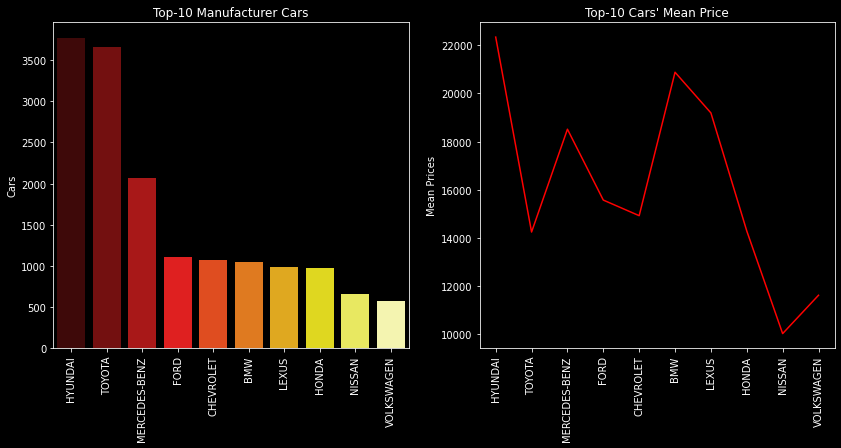

In [ ]:
top10_cars = cars['Manufacturer'].value_counts().sort_values(ascending = False)[:10]
top10_mean_prices = [cars[cars['Manufacturer'] == i]['Price'].mean() for i in list(top10_cars.index)]

# dark theme for plot
plt.style.use('dark_background')

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)
sns.barplot(top10_cars.index, top10_cars.values, palette='hot');
plt.xticks(rotation = 90)
plt.ylabel('Cars')
plt.title('Top-10 Manufacturer Cars');

ax2 = fig.add_subplot(122)
sns.lineplot(top10_cars.index, top10_mean_prices, color='r')
plt.xticks(rotation = 90)
plt.ylabel('Mean Prices')
plt.title("Top-10 Cars' Mean Price")
plt.show();

# Предобработка данных

Удалим первый столбец, содержащий номер товара (ID) - этот набор цифр явно не влияет на прогноз стоимости автомобиля.

In [ ]:
#удаляем первый столбец
cars_new = cars.drop(labels = 'ID', axis=1)

## Удаление дубликатов

Проверим наличие дубликатов в наборе данных.

In [ ]:
print('Количество явных дубликатов:', cars_new.duplicated().sum())

Количество явных дубликатов: 3521


Уберем явные дубликаты из данных.

In [ ]:
cars_dupl = cars_new.drop_duplicates()

In [ ]:
cars_dupl.shape

(15716, 17)

In [ ]:
print(f'Набор данных сократился на {1 - cars_dupl.shape[0] / cars.shape[0]:.0%}')
print('Количество явных дубликатов:', cars_dupl.duplicated().sum())

Набор данных сократился на 18%
Количество явных дубликатов: 0


## Удаление пропущенных значений

In [ ]:
cars_dupl.isna().values.any()

True

В датасете присутствуют пропущенные значения. Исследуем их и удалим. 

In [ ]:
cars_dupl[cars_dupl.isna().values.any(axis=1)]

Price Levy Manufacturer Model  Prod. year Category Leather interior  \
4069    NaN  NaN          NaN   NaN         NaN      NaN              NaN   

     Fuel type Engine volume Mileage  Cylinders Gear box type Drive wheels  \
4069       NaN           NaN     NaN        NaN           NaN          NaN   

     Doors Wheel Color  Airbags  
4069   NaN   NaN   NaN      NaN

In [ ]:
cars_upd = cars_dupl.dropna()
cars_upd.shape

(15715, 17)

## Работа с данными в столбцах

### Doors

In [ ]:
cars_upd['Doors'].value_counts()

04-May    14846
02-Mar      745
>5          124
Name: Doors, dtype: int64

Значения в столбце Количество дверей (Doors) содержит неправильные значения 04-May и 02-Mar. Исправим ошибку.

In [ ]:
cars_upd.loc[:,'Doors'] = cars_upd.loc[:,'Doors'].str.replace('04-May','4-5')
cars_upd.loc[:,'Doors'] = cars_upd.loc[:,'Doors'].str.replace('02-Mar','2-3')
cars_upd['Doors'].value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


4-5    14846
2-3      745
>5       124
Name: Doors, dtype: int64

### Налог (Levy)

In [ ]:
cars_upd['Levy'].value_counts()

-       5679
891      387
765      387
639      340
640      336
        ... 
2177       1
5666       1
3156       1
1719       1
1901       1
Name: Levy, Length: 559, dtype: int64

В колонке Налог (Levy) есть символ "-". Делаем предположение: это обозначение отсутствия налога при продаже. Замним эти пропуски нулями "0".

In [ ]:
cars_upd.loc[:,"Levy"]=cars_upd.loc[:,"Levy"].replace({"-":"0"})
cars_upd.loc[:,'Levy'] = cars_upd.loc[:,'Levy'].apply(lambda x : int(x))
cars_upd['Levy'].describe()

count    15715.000000
mean       561.503213
std        559.271646
min          0.000000
25%          0.000000
50%        639.000000
75%        862.000000
max      11714.000000
Name: Levy, dtype: float64

In [ ]:
print(cars_upd['Levy'].dtype)

int64


### Год производства 

In [ ]:
cars_upd.head()

Price  Levy Manufacturer    Model  Prod. year   Category  \
0  13328.0  1399        LEXUS   RX 450      2010.0       Jeep   
1  16621.0  1018    CHEVROLET  Equinox      2011.0       Jeep   
2   8467.0     0        HONDA      FIT      2006.0  Hatchback   
3   3607.0   862         FORD   Escape      2011.0       Jeep   
4  11726.0   446        HONDA      FIT      2014.0  Hatchback   

  Leather interior Fuel type Engine volume    Mileage  Cylinders  \
0              Yes    Hybrid           3.5  186005 km        6.0   
1               No    Petrol             3  192000 km        6.0   
2               No    Petrol           1.3  200000 km        4.0   
3              Yes    Hybrid           2.5  168966 km        4.0   
4              Yes    Petrol           1.3   91901 km        4.0   

  Gear box type Drive wheels Doors             Wheel   Color  Airbags  
0     Automatic          4x4   4-5        Left wheel  Silver     12.0  
1     Tiptronic          4x4   4-5        Left wheel   Black      8.0  
2      Variator        Front   4-5  Right-hand drive   Black      2.0  
3     Automatic          4x4   4-5        Left wheel   White      0.0  
4     Automatic        Front   4-5        Left wheel  Silver      4.0

Год производства, как число, не информативен при прогназировании. Заменим на возраст автомобиля.

In [ ]:
def age(row):
  age = (2020-row['Prod. year'])
  return age

In [ ]:
cars_upd['Age'] = cars_upd.apply(age, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
cars_upd = cars_upd.drop(labels = 'Prod. year', axis=1)
cars_upd.head()

Price  Levy Manufacturer    Model   Category Leather interior Fuel type  \
0  13328.0  1399        LEXUS   RX 450       Jeep              Yes    Hybrid   
1  16621.0  1018    CHEVROLET  Equinox       Jeep               No    Petrol   
2   8467.0     0        HONDA      FIT  Hatchback               No    Petrol   
3   3607.0   862         FORD   Escape       Jeep              Yes    Hybrid   
4  11726.0   446        HONDA      FIT  Hatchback              Yes    Petrol   

  Engine volume    Mileage  Cylinders Gear box type Drive wheels Doors  \
0           3.5  186005 km        6.0     Automatic          4x4   4-5   
1             3  192000 km        6.0     Tiptronic          4x4   4-5   
2           1.3  200000 km        4.0      Variator        Front   4-5   
3           2.5  168966 km        4.0     Automatic          4x4   4-5   
4           1.3   91901 km        4.0     Automatic        Front   4-5   

              Wheel   Color  Airbags   Age  
0        Left wheel  Silver     12.0  10.0  
1        Left wheel   Black      8.0   9.0  
2  Right-hand drive   Black      2.0  14.0  
3        Left wheel   White      0.0   9.0  
4        Left wheel  Silver      4.0   6.0

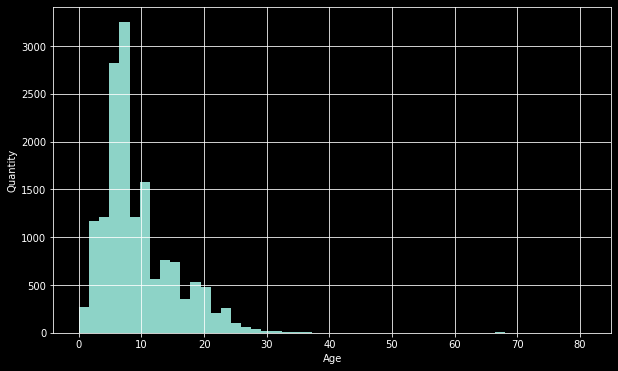

In [ ]:
plt.figure(figsize=[10,6])
ax = cars_upd['Age'].hist(bins=50)
ax.set_xlabel('Age')
ax.set_ylabel('Quantity');

In [ ]:
cars_upd['Age'].describe()

count    15715.000000
mean         9.481260
std          6.012657
min          0.000000
25%          6.000000
50%          8.000000
75%         12.000000
max         81.000000
Name: Age, dtype: float64

### Объем двигателя

Столбец Объем двигателя (Engine volume) содержит слишком много значений, также в некоторых случаях используется слово Turbo.

In [ ]:
cars_upd['Engine volume'].unique()

array(['3.5', '3', '1.3', '2.5', '2', '1.8', '2.4', '4', '1.6', '3.3',
       '2.0 Turbo', '2.2 Turbo', '4.7', '1.5', '4.4', '3.0 Turbo',
       '1.4 Turbo', '3.6', '2.3', '1.5 Turbo', '1.6 Turbo', '2.2',
       '2.3 Turbo', '1.4', '5.5', '2.8 Turbo', '3.2', '3.8', '4.6', '1.2',
       '5', '1.7', '2.9', '0.5', '1.8 Turbo', '2.4 Turbo', '3.5 Turbo',
       '1.9', '2.7', '4.8', '5.3', '0.4', '2.8', '3.2 Turbo', '1.1',
       '2.1', '0.7', '5.4', '1.3 Turbo', '3.7', '1', '2.5 Turbo', '2.6',
       '1.9 Turbo', '4.4 Turbo', '4.7 Turbo', '0.8', '0.2 Turbo', '5.7',
       '4.8 Turbo', '4.6 Turbo', '6.7', '6.2', '1.2 Turbo', '3.4',
       '1.7 Turbo', '6.3 Turbo', '2.7 Turbo', '4.3', '4.2', '2.9 Turbo',
       '0', '4.0 Turbo', '20', '3.6 Turbo', '0.3', '3.7 Turbo', '5.9',
       '5.5 Turbo', '0.2', '2.1 Turbo', '5.6', '6', '0.7 Turbo',
       '0.6 Turbo', '6.8', '4.5', '0.6', '7.3', '0.1', '1.0 Turbo', '6.3',
       '4.5 Turbo', '0.8 Turbo', '4.2 Turbo', '3.1', '5.0 Turbo', '6.4',
       '3

Создадим новый бинарный признак turbo (Yes/No) для опредления типа двигателя. Сначала заполним для всех No.

In [ ]:
cars_upd['turbo'] = 'No'

In [ ]:
cars_upd.head(5)

Price  Levy Manufacturer    Model   Category Leather interior Fuel type  \
0  13328.0  1399        LEXUS   RX 450       Jeep              Yes    Hybrid   
1  16621.0  1018    CHEVROLET  Equinox       Jeep               No    Petrol   
2   8467.0     0        HONDA      FIT  Hatchback               No    Petrol   
3   3607.0   862         FORD   Escape       Jeep              Yes    Hybrid   
4  11726.0   446        HONDA      FIT  Hatchback              Yes    Petrol   

  Engine volume    Mileage  Cylinders Gear box type Drive wheels Doors  \
0           3.5  186005 km        6.0     Automatic          4x4   4-5   
1             3  192000 km        6.0     Tiptronic          4x4   4-5   
2           1.3  200000 km        4.0      Variator        Front   4-5   
3           2.5  168966 km        4.0     Automatic          4x4   4-5   
4           1.3   91901 km        4.0     Automatic        Front   4-5   

              Wheel   Color  Airbags   Age turbo  
0        Left wheel  Silver     12.0  10.0    No  
1        Left wheel   Black      8.0   9.0    No  
2  Right-hand drive   Black      2.0  14.0    No  
3        Left wheel   White      0.0   9.0    No  
4        Left wheel  Silver      4.0   6.0    No

Определим индексы объектов с типом Turbo. Заполним для них признак, как Yes.

In [ ]:

idx_turbo = cars_upd[cars_upd['Engine volume'].str.contains('Turbo')].index
print('Кол-во авто с двигателем Turbo:', len(idx_turbo))

Кол-во авто с двигателем Turbo: 1885


In [ ]:
cars_upd.loc[idx_turbo, 'turbo'] = 'Yes'

Проверим результат.

In [ ]:
RANDOM_STATE = 123

cars_upd[['Engine volume', 'turbo']].sample(5, random_state=RANDOM_STATE)

Engine volume turbo
573       4.4 Turbo   Yes
15246           1.8    No
15069     2.0 Turbo   Yes
7134            1.8    No
14412           1.6    No

In [ ]:
cars_upd[cars_upd['turbo'] == 'Yes'].shape[0]

1885

Преобразование прошло корректно.

Уберем слово Turbo из "Engine volume".

In [ ]:
cars_upd.loc[:,'Engine volume'] = cars_upd.loc[:,'Engine volume'].apply(lambda x : str(x).replace(" Turbo",""))
cars_upd.loc[:,'Engine volume'] = cars_upd.loc[:,'Engine volume'].apply(lambda x : float(x))
print(sorted(cars_upd['Engine volume'].unique()))


[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 5.0, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.2, 6.3, 6.4, 6.7, 6.8, 7.3, 20.0]


### Пробег

Удалим из значений столбца Пробег (Mileage) слово "km", чтобы использовать его в модели как числовой признак.

In [ ]:
cars_upd.loc[:,'Mileage'] = cars_upd.loc[:,'Mileage'].apply(lambda x : str(x).replace("km"," "))
cars_upd.loc[:,'Mileage'] = cars_upd.loc[:,'Mileage'].astype(str).astype(int)
cars_upd['Mileage'].describe().apply(lambda x: format(x, 'f'))

count         15715.000000
mean        1837501.705632
std        53549488.795858
min               0.000000
25%           66566.500000
50%          121000.000000
75%          180000.000000
max      2147483647.000000
Name: Mileage, dtype: object

# EDA 

Для дальнейшей работы с данными преобразуем названия столбцов в "змеиный регистр".

In [ ]:
cars_upd.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower().replace(' ', '_') for name in cars_upd.columns]

In [ ]:
cars_upd.columns

Index(['price', 'levy', 'manufacturer', 'model', 'category',
       'leather_interior', 'fuel_type', 'engine_volume', 'mileage',
       'cylinders', 'gear_box_type', 'drive_wheels', 'doors', 'wheel', 'color',
       'airbags', 'age', 'turbo'],
      dtype='object')

## Поиск аномалий

Поиск аномалий в наборе данных позволит удалить уникальные автомобили, стоимость которых должна рассматриваться по отдельности для каждого конкретного случая.  

Рассмотрим возраст автомобиля (Age).

In [ ]:
fig = px.box(cars_upd, x='age', orientation="h", notched=True)
fig.update_layout(height=300, width=900)

Удалим выбросы: машины старше 40 лет. Количество машин старше незначительно.

In [ ]:
cars_filter = cars_upd.query('0<=age<41')

In [ ]:
cars_filter.shape

(15693, 18)

Следующий признак для исследования - объем двигателя (Engine volume).

In [ ]:
fig = px.box(cars_filter, x="engine_volume", orientation="h", notched=True)
fig.update_layout(height=300, width=900)
fig.show()

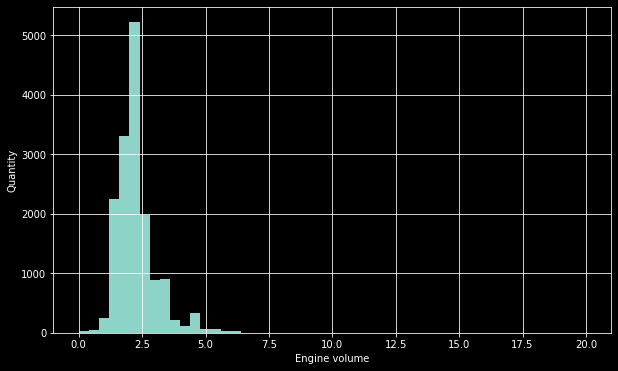

In [ ]:
plt.figure(figsize=[10,6])
ax = cars_upd['engine_volume'].hist(bins=50)
ax.set_xlabel('Engine volume')
ax.set_ylabel('Quantity');

Из графиков видно, что рассматривать автомобили с объемом двигателя (Engine volume) больше 7 л нецелеобразно.

In [ ]:
cars_filter = cars_filter.query('1<engine_volume<7')

In [ ]:
cars_filter.shape

(15497, 18)

Следующий признак для исследования - levy.

In [ ]:
fig = px.box(cars_filter, x="levy", orientation="h", notched=True)
fig.update_layout(height=300, width=900)
fig.show()

Удалим из данных автомобили более 2500.

In [ ]:
cars_filter = cars_filter.query('levy<2500')

Следующий признак для исследования - пробег, mileage.

In [ ]:
fig = px.box(cars_filter, x="mileage", orientation="h", notched=True)
fig.update_layout(height=300, width=900)
fig.show()

In [ ]:
lower = cars_filter['mileage'].quantile(.025)
upper = cars_filter['mileage'].quantile(.975)

print(f'95% доверительный интервал пробега от {lower:.0f} км до {upper:.0f} км')

95% доверительный интервал пробега от 0 км до 384090 км


Удалим из данных автомобили с пробегом более 385000 км.

In [ ]:
cars_filter = cars_filter.query('mileage<385000')

Также не будем верить сверхнизким и аномально высоким стоимостям (Price) автомобиля. 


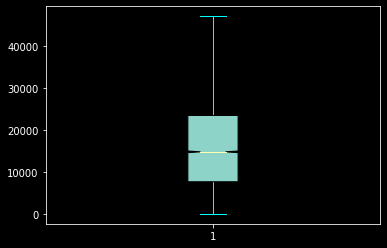

In [ ]:
c = 'cyan'
plt.boxplot(cars_filter['price'], notch=True, patch_artist=True,
                    capprops=dict(color=c), whiskerprops=dict(color=c), 
                    flierprops=dict(markeredgecolor=c), showfliers=0);

In [ ]:
lower = cars_filter['price'].quantile(.025)
upper = cars_filter['price'].quantile(.975)

print(f'95% доверительный интервал стоимости от {lower:.0f} евро до {upper:.0f} $')

95% доверительный интервал стоимости от 157 евро до 64463 $


Удалим из данных автомобили стоимостью меньше 100 долларов и выше 64 тыс. долларов.

In [ ]:
cars_filter = cars_filter.query('100<=price<=64000')
cars_filter = cars_filter.reset_index(drop=True)

In [ ]:
cars_filter['price'].describe()

count    14362.000000
mean     17224.939215
std      13133.464403
min        100.000000
25%       7840.000000
50%      14740.000000
75%      22894.000000
max      63976.000000
Name: price, dtype: float64

In [ ]:
cars_filter.shape

(14362, 18)

## Признак с большим количеством значений 

Признак с большим количеством разных значений может отрицательно сказаться на качестве модели. В нашем наборе данных такой признак модель автомобиля (model).

In [ ]:
print('Количество уникальных значений', cars_filter['model'].nunique())

Количество уникальных значений 1441


Делаем гипотезу, что можно убрать модель автомобиля из датасета для лучшей предсказательности.

In [ ]:
#удаляем столбец 'model'
cars_filter = cars_filter.drop(labels = 'model', axis=1)

## Проверка мультиколлинеарности

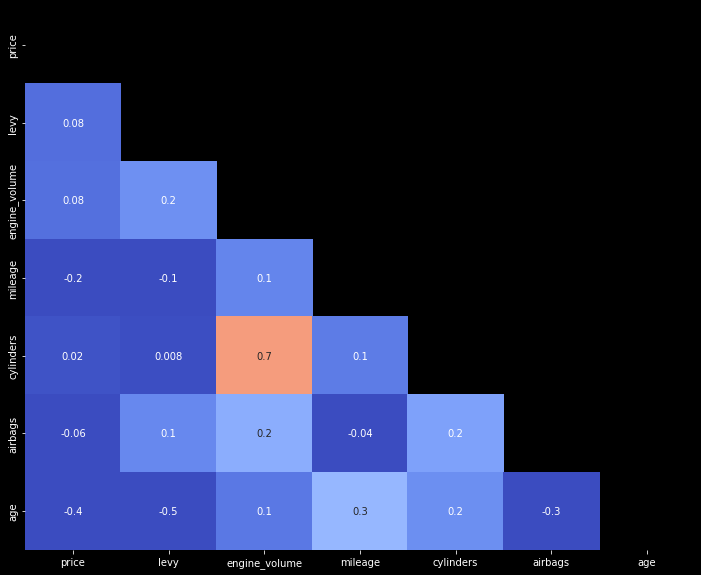

In [ ]:
plt.figure(figsize = (12,10))
matrix = np.triu(cars_filter.corr())
sns.heatmap(cars_filter.corr(),annot = True, fmt='.1g', mask=matrix, vmin=0,
            vmax=1, cmap= 'coolwarm', cbar=0)

Самая высокая корреляция наблюдается между числом цилиндров (cylinders) и объемом двигателя (engine_volume).

Найдем коэффициент корреляции с помощью библиотеки phik — определим меру нелинейной связи между признаками в исходных данных. Определим список числовых признаков как interval_cols. Посчитаем коэффициенты корреляции для признаков и построим тепловую карту.

In [ ]:
numeric_features = ['price', 'levy', 'engine_volume', 'mileage',
                    'cylinders','airbags', 'age']

In [ ]:
# phik matrix
phik_overview = cars_filter.phik_matrix(interval_cols=numeric_features)

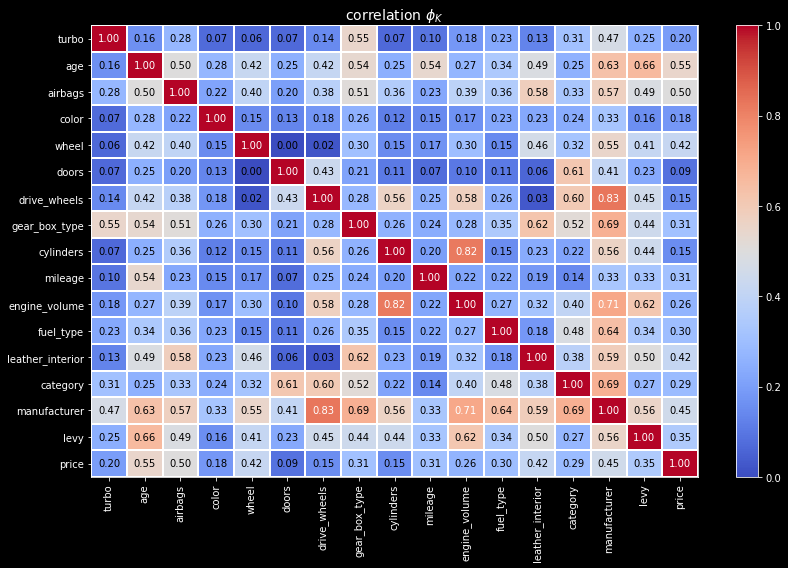

In [ ]:
# heatmap of phik results

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="coolwarm", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(12, 8))
plt.tight_layout()

Рассмотрим распределение значений коэффициентов корреляции:

* Обнаружена сильная связь между признаками manufacturer и drive_wheels, а также между engine_volume и cylinders.

* Признак color показывает нулевую корреляцию, т.е. слабо связан с другими признаками. Это также может помешать обучению модели.

* Целевой признак явно ни с чем не коррелирует. Отметим слабую связь price с doors.

При оценке корреляций следует обратить внимание не только на коэффициенты, но и на их статистическую значимость. Потому что в итоге большая корреляция может оказаться статистически незначимой, и наоборот. Найдем статистическую значимость корреляции с помощью библиотеки phik.

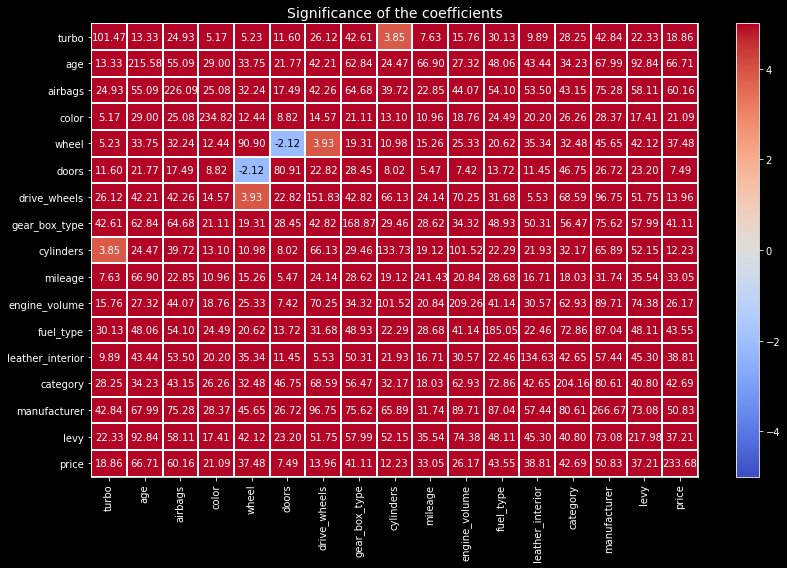

In [ ]:
# phik significance matrix
significance_overview = cars_filter.significance_matrix(interval_cols=numeric_features)

# heatmap of significance results
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, color_map="coolwarm", 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1, figsize=(12, 8))
plt.tight_layout()

Получены относительно высокие значения коэффициента для почти всех признаков, такие - статистически значимы. Поэтому мы можем довериться коэффициентам корреляции из прошлого анализа. 

Уберем из данных признаки:
* color. показывает нулевую корреляцию
* drive_wheels. manufacturer лучше связан с другими признаками
* cylinders. engine_volume лучше связан с другими признаками

Обновим данные и уберем мультикорреальные признаки, построим тепловую карту для проверки результата.

In [ ]:
# remove the features with correlation 
cars_filter = cars_filter.drop(['drive_wheels', 'color', 'cylinders'], axis=1 )

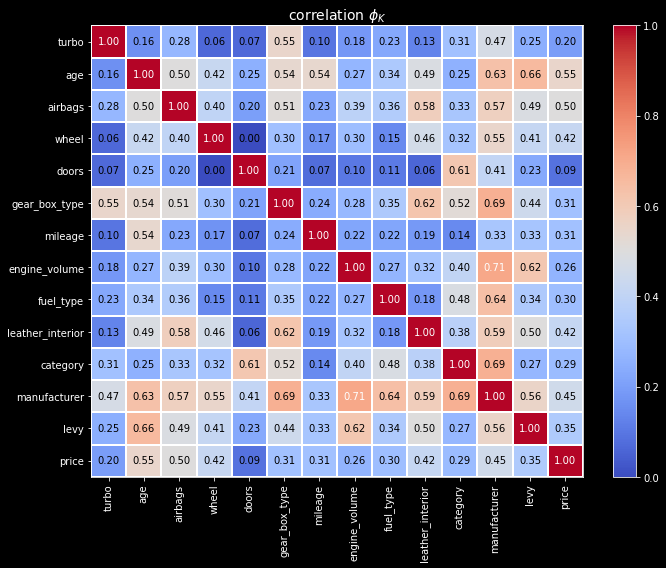

In [ ]:
# updated phik matrix
phik_overview_upd = cars_filter.phik_matrix(interval_cols=numeric_features)

# heatmap of updated phik results
plot_correlation_matrix(phik_overview_upd.values, 
                        x_labels=phik_overview_upd.columns, 
                        y_labels=phik_overview_upd.index, 
                        vmin=0, vmax=1, color_map="coolwarm", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(10, 8))
plt.tight_layout()

In [ ]:
cars_filter.shape

(14362, 14)

# Обучение моделей

## Кодирование признаков

Признаки содержат категориальные переменные. Применим технику Ordinal Encoding, кодирование по номеру категории, чтобы закодировать цифрами выраженные в тексте категории.

In [ ]:
encoder = OrdinalEncoder()

category = ['manufacturer', 'category', 'leather_interior', 'fuel_type', 
            'gear_box_type', 'wheel', 'doors', 'turbo']
       
cars_ordinal = cars_filter[category]
cars_ordinal = pd.DataFrame(encoder.fit_transform(cars_ordinal),
                            columns=cars_ordinal.columns)

cars_ordinal = cars_ordinal.join(cars_filter[['price', 'levy', 'engine_volume', 
                                              'mileage','airbags', 'age']])

cars_ordinal.head()

manufacturer  category  leather_interior  fuel_type  gear_box_type  wheel  \
0          29.0       4.0               1.0        2.0            0.0    0.0   
1           7.0       4.0               0.0        5.0            2.0    0.0   
2          19.0       3.0               0.0        5.0            3.0    1.0   
3          14.0       4.0               1.0        2.0            0.0    0.0   
4          19.0       3.0               1.0        5.0            0.0    0.0   

   doors  turbo    price  levy  engine_volume  mileage  airbags   age  
0    1.0    0.0  13328.0  1399            3.5   186005     12.0  10.0  
1    1.0    0.0  16621.0  1018            3.0   192000      8.0   9.0  
2    1.0    0.0   8467.0     0            1.3   200000      2.0  14.0  
3    1.0    0.0   3607.0   862            2.5   168966      0.0   9.0  
4    1.0    0.0  11726.0   446            1.3    91901      4.0   6.0

## Определение выборок

Тестовой выборки нет. Значит, данные нужно разбить на две части: обучающую и тестовую. Исходные данные разбиваем в соотношении 3:1. Зафиксируем псевдослучайность для алгоритма обучения, укажем параметр random_state.

In [ ]:
X = cars_ordinal.drop('price',axis=1)
y = cars_ordinal['price']

In [ ]:
# Split the dataset: 75% vs 25% 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=RANDOM_STATE)

In [ ]:
X_train.shape

(10771, 13)

In [ ]:
X_test.shape

(3591, 13)

## Масштабирование признаков

В общем случае, значения в столбцах имеют неоднородную размерность. Чтобы алгоритмам было легче обучать модели, признаки приводятся к одному масштабу.

In [ ]:
pd.options.mode.chained_assignment = None

# list of numerical features for scaling
numeric = ['levy', 'engine_volume', 
           'mileage','airbags', 'age']

# fit scaler on train data
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

scaler = StandardScaler()
scaler.fit(X_train_scaled[numeric])

# scaling of numeric features
X_train_scaled[numeric] = scaler.transform(X_train_scaled[numeric])
X_test_scaled[numeric] = scaler.transform(X_test_scaled[numeric])

X_train_scaled[numeric].head()

levy  engine_volume   mileage   airbags       age
6007  0.438982      -0.548070 -0.112050  0.350531  0.097241
3521 -0.044267      -0.817263 -0.585419 -0.638032 -0.620884
1112  1.291407       1.740068 -0.338645 -0.638032 -0.082290
2760 -0.044267      -0.817263 -0.980753  0.844812 -0.620884
8995  1.612882       2.413050  0.118777  1.339093 -0.082290

In [ ]:
X_train_scaled.shape

(10771, 13)

## Случайный лес

Случайный лес для регрессии - это алгортитм, который обучает множество независимых деревьев, а потом принимает решение, усредняя их ответы.

Напишем функцию для обучения модели и расчета метрик ее предсказаний.

In [ ]:
def model_metrics(predict_model, y_test):
    
    mae = np.mean(abs(predict_model-y_test))
    rmse = np.sqrt(np.mean((predict_model-y_test)**2))
    rae = np.mean(abs(predict_model-y_test))/np.mean(abs(y_test-np.mean(y_test)))
    rse = np.mean((predict_model-y_test)**2)/np.mean((y_test-np.mean(y_test))**2)
    r2 = r2_score(y_test, predict_model)
    print("The R-squared value: {0:0.4f}".format(r2)) 
    print("Mean Absolute Error: {0:0.1f}".format(mae)) 
    print("Root Mean Squared Error: {0:0.1f}".format(rmse)) 
    print("Relative Absolute Error: {0:0.4f}".format(rae)) 
    print("Relative Squared Error: {0:0.4f}".format(rse))
    return r2 

In [ ]:
rf = RandomForestRegressor(random_state=RANDOM_STATE)

In [ ]:
%%time

rf.fit(X_train_scaled, y_train)
predict_rf = rf.predict(X_test_scaled)

score_rf = model_metrics(predict_rf, y_test)

The R-squared value: 0.7041
Mean Absolute Error: 4483.1
Root Mean Squared Error: 7269.3
Relative Absolute Error: 0.4356
Relative Squared Error: 0.2959
CPU times: user 4 s, sys: 73 ms, total: 4.07 s
Wall time: 4.08 s


Выполним анализ важности признаков выбранной модели.

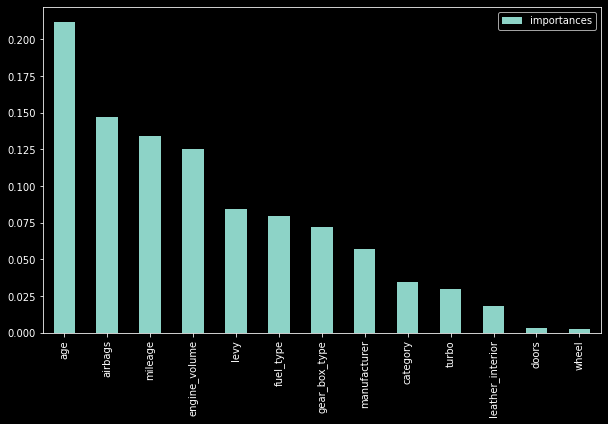

In [ ]:
df_feature_importance = pd.DataFrame(rf.feature_importances_, 
                                     index = X_train_scaled.columns, 
                                     columns=['importances']).sort_values(by='importances', ascending=False)


df_feature_importance.plot(kind='bar', figsize=[10,6]);

## Градиентный бустинг

Градиентный бустинг — это техника машинного обучения для задач регрессии, которая строит модель предсказания в форме ансамбля слабых предсказывающих моделей, обычно деревьев решений. Это техника использует идею о том, что следующая модель будет учится на ошибках предыдущей с каждой итерацией. 

In [ ]:
gb = GradientBoostingRegressor(random_state=RANDOM_STATE)

In [ ]:
%%time

gb.fit(X_train_scaled, y_train)
predict_gb = gb.predict(X_test_scaled)

score_gb = model_metrics(predict_gb, y_test)

The R-squared value: 0.6282
Mean Absolute Error: 5607.2
Root Mean Squared Error: 8147.9
Relative Absolute Error: 0.5448
Relative Squared Error: 0.3718
CPU times: user 1.16 s, sys: 3 µs, total: 1.16 s
Wall time: 1.16 s


Выполним анализ важности признаков выбранной модели.

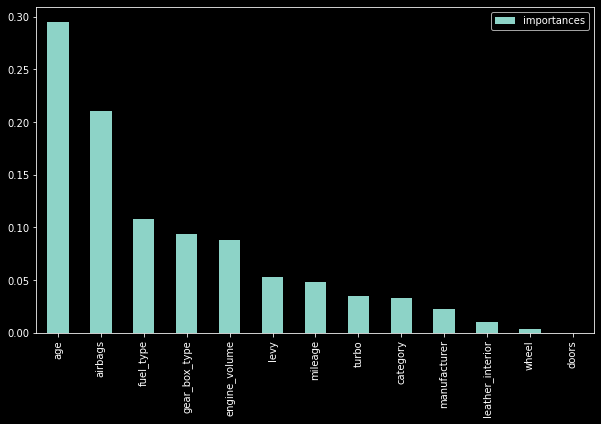

In [ ]:
df_feature_importance = pd.DataFrame(gb.feature_importances_, 
                                     index = X_train_scaled.columns, 
                                     columns=['importances']).sort_values(by='importances', ascending=False)


df_feature_importance.plot(kind='bar', figsize=[10,6]);

## AutoGluon

AutoGluon построен на основе ML-библиотеки Gluon для создания моделей из набора готовых оптимизированных элементов. Он работает с табличными данными и чтобы получить готовую модель, нам потребуется указать, к какому сроку инструмент должен выдать обученную модель — AutoGluon распределит имеющиеся вычислительные мощности так, чтобы за отведённое время найти наиболее эффективную модель.

In [ ]:
time_limit = 60 
metric = 'r2'

In [ ]:
train =  X_train_scaled.join(y_train)
test =  X_test_scaled.join(y_test)

In [ ]:
predictor = TabularPredictor(label='price', eval_metric=metric).fit(train_data = train, time_limit=time_limit, verbosity = 0,presets='best_quality')
predictor.leaderboard(test, silent=True)

Level 25:autogluon.common.utils.utils:No path specified. Models will be saved in: "AutogluonModels/ag-20221030_144808/"


model  score_test  score_val  pred_time_test  \
0      LightGBMXT_BAG_L2    0.734969   0.734060        3.978894   
1    WeightedEnsemble_L3    0.734969   0.734060        3.980863   
2    WeightedEnsemble_L2    0.734105   0.734698        3.533714   
3      LightGBMXT_BAG_L1    0.731260   0.729139        3.421383   
4  KNeighborsDist_BAG_L1    0.618540   0.618449        0.107757   
5  KNeighborsUnif_BAG_L1    0.614536   0.611410        0.106232   

   pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  \
0       3.257893  62.923587                 0.343521                0.234467   
1       3.258618  62.927481                 0.001970                0.000725   
2       2.819912  43.755483                 0.004574                0.000680   
3       2.613884  43.516316                 3.421383                2.613884   
4       0.205347   0.034199                 0.107757                0.205347   
5       0.204195   0.035742                 0.106232                0.204195   

   fit_time_marginal  stack_level  can_infer  fit_order  
0          19.337330            2       True          5  
1           0.003894            3       True          6  
2           0.204969            2       True          4  
3          43.516316            1       True          3  
4           0.034199            1       True          2  
5           0.035742            1       True          1

LightGBMXT_BAG_L2 - показывает хорошее качество. Найдем метрики для нее.

In [ ]:
predict_aut = predictor.predict(test, model='LightGBMXT_BAG_L2')

score_aut = model_metrics(predict_aut, test['price'])

The R-squared value: 0.7350
Mean Absolute Error: 4267.1
Root Mean Squared Error: 6879.6
Relative Absolute Error: 0.4146
Relative Squared Error: 0.2650


In [ ]:
feature_importance_aut = predictor.feature_importance(test, model='LightGBMXT_BAG_L2')
feature_importance_aut

importance    stddev       p_value  n  p99_high   p99_low
age                 0.588635  0.028655  6.718152e-07  5  0.647637  0.529633
airbags             0.436449  0.019116  4.404692e-07  5  0.475809  0.397089
gear_box_type       0.171033  0.010255  1.543534e-06  5  0.192148  0.149918
levy                0.142439  0.006632  5.623465e-07  5  0.156094  0.128783
manufacturer        0.138639  0.003407  4.375361e-08  5  0.145655  0.131623
engine_volume       0.107025  0.003665  1.647557e-07  5  0.114571  0.099479
category            0.091254  0.004822  9.323332e-07  5  0.101183  0.081325
mileage             0.078935  0.009623  2.598675e-05  5  0.098749  0.059122
leather_interior    0.068187  0.005083  3.678328e-06  5  0.078653  0.057721
fuel_type           0.056998  0.003670  2.051194e-06  5  0.064555  0.049441
turbo               0.055422  0.006328  2.004087e-05  5  0.068450  0.042393
wheel               0.008025  0.000929  2.114099e-05  5  0.009937  0.006113
doors               0.002245  0.000894  2.468851e-03  5  0.004086  0.000405

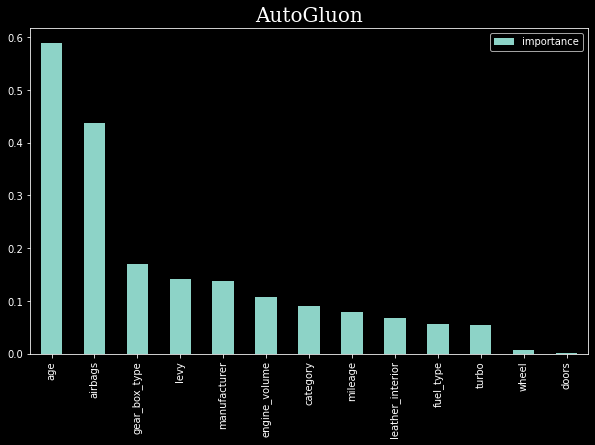

In [ ]:
df_feature_importance = pd.DataFrame(feature_importance_aut['importance'], 
                                     index = feature_importance_aut.index)


df_feature_importance.plot(kind='bar', figsize=[10,6])
font = {'family':'serif','color':'w','size':20}
plt.title('AutoGluon', fontdict=font);

## Вывод

Мы выполнили следующие этапы практической работы:

* Выбран набор данных от Kaggle
* Проведен разведочный анализ
* Очищены данные и убраны выбросы
* Оцифрованы категориальные признаки
* Подготовлена модель и обучена в следующих библиотеках:

    * Scikit-learn. Random Forest Regressor
    * Scikit-learn. Gradient Boosting Regressor
    * AutoGluon

Сделаем сводную таблицу по результатам тестирования.

In [ ]:
pd.DataFrame({'модель':['Random Forest Regressor','Gradient Boosting Regressor', 'AutoGluon'],
              'R2.обучение':[score_rf, score_gb, score_aut],
              'скорость':['средняя', 'высокая', 'низкая']})

модель  R2.обучение скорость
0      Random Forest Regressor     0.704098  средняя
1  Gradient Boosting Regressor     0.628246  высокая
2                    AutoGluon     0.734969   низкая

Предсказание AutoGluon наиболее точные на обучении по метрике R2. Случайный лес предсказывает чуть хуже, но эта модель более простая и быстрее работает. Возьмем эти модели для теста на новых данных.

# Прогноз на новых данных

Выполним прогнозирование модели на новых данных. Необходимо сгенерировать выборку, используя исходные данные.

In [ ]:
# используя pandas: Случайная выборка DataFrame с заменой
new_data = cars.sample(frac=0.2, replace=False, random_state=RANDOM_STATE)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3847 entries, 14672 to 16644
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                3847 non-null   object 
 1   Price             3844 non-null   float64
 2   Levy              3844 non-null   object 
 3   Manufacturer      3844 non-null   object 
 4   Model             3844 non-null   object 
 5   Prod. year        3844 non-null   float64
 6   Category          3844 non-null   object 
 7   Leather interior  3844 non-null   object 
 8   Fuel type         3844 non-null   object 
 9   Engine volume     3844 non-null   object 
 10  Mileage           3844 non-null   object 
 11  Cylinders         3844 non-null   float64
 12  Gear box type     3844 non-null   object 
 13  Drive wheels      3844 non-null   object 
 14  Doors             3844 non-null   object 
 15  Wheel             3844 non-null   object 
 16  Color             3844 non-null   obj

## Подготовка признаков

Выполним такую же предобработку данных и подготовим выборки для прогноза.

In [ ]:
new_data = new_data.drop(labels = 'ID', axis=1)

In [ ]:
new_data[new_data.isna().values.any(axis=1)]

Price Levy Manufacturer Model  Prod. year Category Leather interior  \
13328    NaN  NaN          NaN   NaN         NaN      NaN              NaN   
15406    NaN  NaN          NaN   NaN         NaN      NaN              NaN   
17846    NaN  NaN          NaN   NaN         NaN      NaN              NaN   

      Fuel type Engine volume Mileage  Cylinders Gear box type Drive wheels  \
13328       NaN           NaN     NaN        NaN           NaN          NaN   
15406       NaN           NaN     NaN        NaN           NaN          NaN   
17846       NaN           NaN     NaN        NaN           NaN          NaN   

      Doors Wheel Color  Airbags  
13328   NaN   NaN   NaN      NaN  
15406   NaN   NaN   NaN      NaN  
17846   NaN   NaN   NaN      NaN

In [ ]:
new_data = new_data.dropna()
new_data.shape

(3844, 17)

In [ ]:
new_data['Doors'] = new_data['Doors'].str.replace('04-May','4-5')
new_data['Doors'] = new_data['Doors'].str.replace('02-Mar','2-3')
new_data['Doors'].value_counts()

4-5    3681
2-3     140
>5       23
Name: Doors, dtype: int64

In [ ]:
new_data["Levy"] = new_data["Levy"].replace({"-":"0"})
new_data['Levy'] = new_data['Levy'].apply(lambda x : int(x))
new_data['Levy'].describe()

count    3844.000000
mean      625.231270
std       535.620236
min         0.000000
25%         0.000000
50%       642.000000
75%       911.000000
max      5332.000000
Name: Levy, dtype: float64

In [ ]:
new_data['Age'] = new_data.apply(age, axis=1)

In [ ]:
new_data = new_data.drop(labels = 'Prod. year', axis=1)

In [ ]:
new_data['turbo'] = 'No'

In [ ]:
idx_turbo = new_data[new_data['Engine volume'].str.contains('Turbo')].index
print('Кол-во авто с двигателем Turbo:', len(idx_turbo))

Кол-во авто с двигателем Turbo: 389


In [ ]:
new_data.loc[idx_turbo, 'turbo'] = 'Yes'

In [ ]:
new_data[new_data['turbo'] == 'Yes'].shape[0]

389

In [ ]:
new_data['Engine volume'] = new_data['Engine volume'].apply(lambda x : str(x).replace(" Turbo",""))
new_data['Engine volume'] = new_data['Engine volume'].apply(lambda x : float(x))

In [ ]:
new_data['Mileage'] = new_data['Mileage'].apply(lambda x : str(x).replace("km"," "))
new_data['Mileage'] = new_data['Mileage'].astype(str).astype(int)

In [ ]:
new_data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower().replace(' ', '_') for name in cars_upd.columns]
new_data.columns

Index(['price', 'levy', 'manufacturer', 'model', 'category',
       'leather_interior', 'fuel_type', 'engine_volume', 'mileage',
       'cylinders', 'gear_box_type', 'drive_wheels', 'doors', 'wheel', 'color',
       'airbags', 'age', 'turbo'],
      dtype='object')

In [ ]:
#удаляем столбцы
new_data = new_data.drop(['model', 'drive_wheels', 'color', 'cylinders'], axis=1)

In [ ]:
new_data.shape

(3844, 14)

In [ ]:
new_data = new_data.reset_index(drop=True)

In [ ]:
new_ordinal = new_data[category]
new_ordinal = pd.DataFrame(encoder.fit_transform(new_ordinal),
                            columns=new_ordinal.columns)

new_ordinal = new_ordinal.join(new_data[['price', 'levy', 'engine_volume', 
                                              'mileage','airbags', 'age']])

new_ordinal.head()

manufacturer  category  leather_interior  fuel_type  gear_box_type  wheel  \
0          48.0       9.0               1.0        4.0            0.0    0.0   
1           2.0       9.0               0.0        4.0            1.0    0.0   
2          13.0       6.0               0.0        1.0            1.0    0.0   
3          18.0       4.0               1.0        1.0            0.0    0.0   
4          18.0       9.0               1.0        1.0            0.0    0.0   

   doors  turbo    price  levy  engine_volume   mileage  airbags   age  
0    1.0    0.0  17876.0   584            1.8     97000      0.0   6.0  
1    1.0    0.0   9095.0     0            2.8  55556665      6.0  18.0  
2    1.0    1.0  12231.0     0            2.5    400000      2.0  21.0  
3    1.0    0.0  26594.0   642            2.0    138525      4.0   8.0  
4    1.0    0.0  24709.0   528            1.6    133480      4.0   6.0

In [ ]:
X_new = new_ordinal.drop('price',axis=1)
y_new = new_ordinal['price']

In [ ]:
pd.options.mode.chained_assignment = None

X_new_scaled = X_new.copy()

# scaling of numeric features
X_new_scaled[numeric] = scaler.transform(X_new_scaled[numeric])

X_new_scaled.head()

manufacturer  category  leather_interior  fuel_type  gear_box_type  wheel  \
0          48.0       9.0               1.0        4.0            0.0    0.0   
1           2.0       9.0               0.0        4.0            1.0    0.0   
2          13.0       6.0               0.0        1.0            1.0    0.0   
3          18.0       4.0               1.0        1.0            0.0    0.0   
4          18.0       9.0               1.0        1.0            0.0    0.0   

   doors  turbo      levy  engine_volume     mileage   airbags       age  
0    1.0    0.0  0.071879      -0.548070   -0.385071 -1.626594 -0.620884  
1    1.0    0.0 -1.139354       0.797894  687.871891 -0.143750  1.533492  
2    1.0    1.0 -1.139354       0.394105    3.375173 -1.132313  2.072086  
3    1.0    0.0  0.192172      -0.278877    0.130256 -0.638032 -0.261821  
4    1.0    0.0 -0.044267      -0.817263    0.067647 -0.638032 -0.620884

## Тест модели

Обучим модели на тестовой выборке и оценим качество их предсказаний на тесте по метрике R2 c помощью функции model_metrics.

Случайный лес:

In [ ]:
%%time

predict_rf_new = rf.predict(X_new_scaled)

score_rf_new = model_metrics(predict_rf_new, y_new)

The R-squared value: 0.4529
Mean Absolute Error: 4953.9
Root Mean Squared Error: 14736.3
Relative Absolute Error: 0.4118
Relative Squared Error: 0.5471
CPU times: user 159 ms, sys: 1.01 ms, total: 160 ms
Wall time: 164 ms


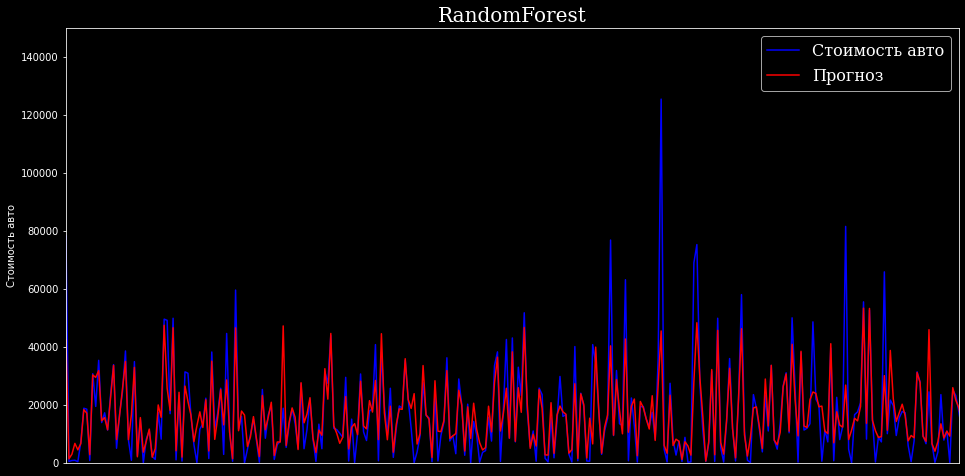

In [ ]:
# plot of target and predict
plt.figure(figsize=(16, 8))
plt.plot(y_new.index, 
         y_new, 
         'b-', label='Стоимость авто')

plt.plot(y_new.index, 
         predict_rf_new,
         'r-', label='Прогноз')

style = {'family':'serif','size':16}
plt.xlim(1700, 2000)
plt.ylim(0, 150000)
plt.xticks([])

plt.ylabel('Стоимость авто')
plt.legend(prop=style)
plt.title('RandomForest', fontdict=font);

AutoGluon:

In [ ]:
full_new =  X_new_scaled.join(y_new)

In [ ]:
%%time

predict_aut_new = predictor.predict(full_new, model='LightGBMXT_BAG_L2')

score_aut_new = model_metrics(predict_aut_new, full_new['price'])

The R-squared value: 0.4165
Mean Absolute Error: 6469.7
Root Mean Squared Error: 15219.1
Relative Absolute Error: 0.5378
Relative Squared Error: 0.5835
CPU times: user 7.15 s, sys: 69.4 ms, total: 7.22 s
Wall time: 4.26 s


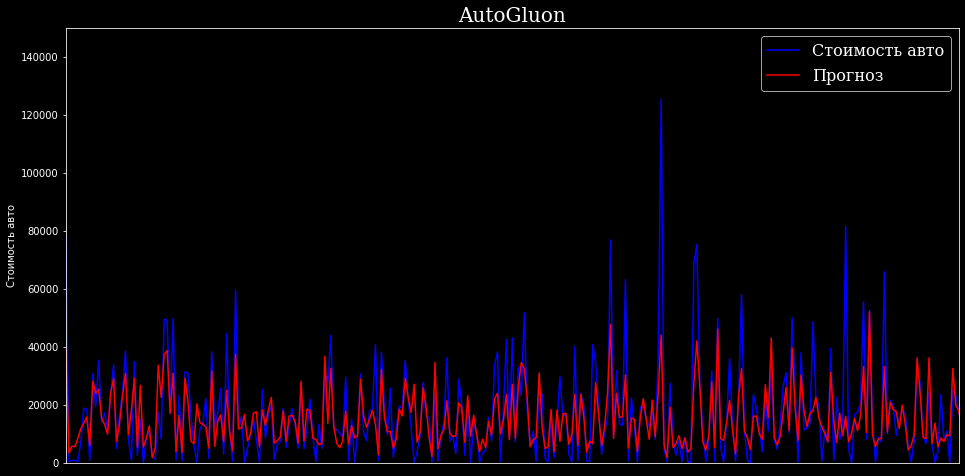

In [ ]:
# plot of target and predict
plt.figure(figsize=(16, 8))
plt.plot(y_new.index, 
         y_new, 
         'b-', label='Стоимость авто')

plt.plot(y_new.index, 
         predict_aut_new,
         'r-', label='Прогноз')

style = {'family':'serif','size':16}
plt.xlim(1700, 2000)
plt.ylim(0, 150000)
plt.xticks([])

plt.ylabel('Стоимость авто')
plt.legend(prop=style)
plt.title('AutoGluon', fontdict=font);

Модели плохо предсказывают из-за присутствия аномальных значений в новых данных.

## Подготовка очищенных данных

Выполним такую же очистку данных от выбросов и подготовим выборки для прогноза.

In [ ]:
new_filter = new_data.query('0<=age<41')

In [ ]:
new_filter = new_filter.query('1<engine_volume<7')

In [ ]:
new_filter = new_filter.query('levy<2500')

In [ ]:
new_filter = new_filter.query('mileage<385000')

In [ ]:
new_filter = new_filter.query('100<=price<=64000')
new_filter = new_filter.reset_index(drop=True)
new_filter.shape

(3522, 14)

In [ ]:
new_filter_ordinal = new_filter[category]
new_filter_ordinal = pd.DataFrame(encoder.fit_transform(new_filter_ordinal),
                            columns=new_filter_ordinal.columns)

new_filter_ordinal = new_filter_ordinal.join(new_filter[['price', 'levy', 'engine_volume', 
                                              'mileage','airbags', 'age']])

new_filter_ordinal.head()

manufacturer  category  leather_interior  fuel_type  gear_box_type  wheel  \
0          44.0       9.0               1.0        4.0            0.0    0.0   
1          16.0       4.0               1.0        1.0            0.0    0.0   
2          16.0       9.0               1.0        1.0            0.0    0.0   
3          41.0       9.0               0.0        4.0            0.0    1.0   
4          41.0       9.0               1.0        4.0            2.0    0.0   

   doors  turbo    price  levy  engine_volume  mileage  airbags   age  
0    1.0    0.0  17876.0   584            1.8    97000      0.0   6.0  
1    1.0    0.0  26594.0   642            2.0   138525      4.0   8.0  
2    1.0    0.0  24709.0   528            1.6   133480      4.0   6.0  
3    1.0    0.0   7213.0     0            2.0   180000      0.0  21.0  
4    1.0    0.0  22580.0   777            2.5   133000     10.0   6.0

In [ ]:
X_new_filt = new_filter_ordinal.drop('price',axis=1)
y_new_filt = new_filter_ordinal['price']

In [ ]:
pd.options.mode.chained_assignment = None

X_scld_flt = X_new_filt.copy()

# scaling of numeric features
X_scld_flt[numeric] = scaler.transform(X_scld_flt[numeric])

X_scld_flt.head()

manufacturer  category  leather_interior  fuel_type  gear_box_type  wheel  \
0          44.0       9.0               1.0        4.0            0.0    0.0   
1          16.0       4.0               1.0        1.0            0.0    0.0   
2          16.0       9.0               1.0        1.0            0.0    0.0   
3          41.0       9.0               0.0        4.0            0.0    1.0   
4          41.0       9.0               1.0        4.0            2.0    0.0   

   doors  turbo      levy  engine_volume   mileage   airbags       age  
0    1.0    0.0  0.071879      -0.548070 -0.385071 -1.626594 -0.620884  
1    1.0    0.0  0.192172      -0.278877  0.130256 -0.638032 -0.261821  
2    1.0    0.0 -0.044267      -0.817263  0.067647 -0.638032 -0.620884  
3    1.0    0.0 -1.139354      -0.278877  0.644963 -1.626594  2.072086  
4    1.0    0.0  0.472166       0.394105  0.061690  0.844812 -0.620884

## Тест модели на очищенных данных

Обучим модели на тренировочной выборке и оценим качество их предсказаний на тесте по метрике R2 c помощью функции model_metrics.

Случайный лес:

In [ ]:
%%time

predict_rf_flt = rf.predict(X_scld_flt)

score_rf_flt = model_metrics(predict_rf_flt, y_new_filt)

The R-squared value: 0.7866
Mean Absolute Error: 3710.5
Root Mean Squared Error: 6031.9
Relative Absolute Error: 0.3661
Relative Squared Error: 0.2134
CPU times: user 131 ms, sys: 1.98 ms, total: 133 ms
Wall time: 140 ms


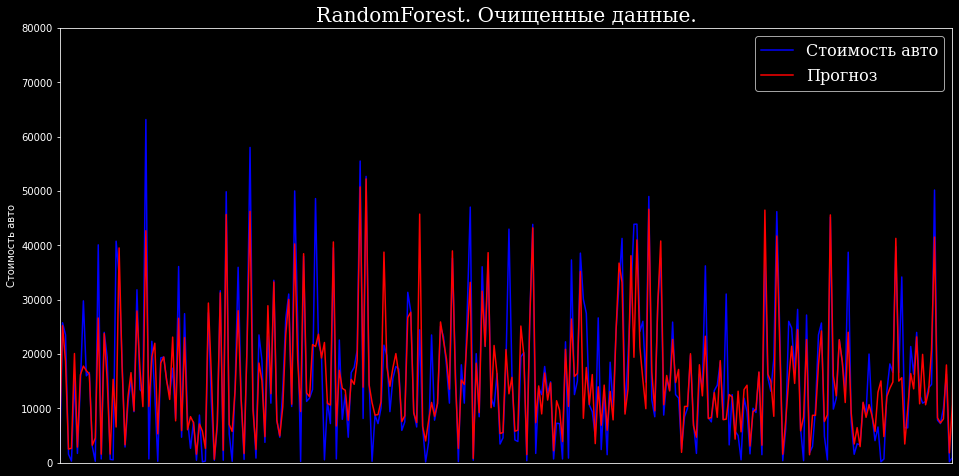

In [ ]:
# plot of target and predict
plt.figure(figsize=(16, 8))
plt.plot(y_new_filt.index, 
         y_new_filt, 
         'b-', label='Стоимость авто')

plt.plot(y_new_filt.index, 
         predict_rf_flt,
         'r-', label='Прогноз')

style = {'family':'serif','size':16}
plt.xlim(1700, 2000)
plt.ylim(0, 80000)
plt.xticks([])

plt.ylabel('Стоимость авто')
plt.legend(prop=style)
plt.title('RandomForest. Очищенные данные.', fontdict=font);

AutoGluon:

In [ ]:
full_new_flt =  X_scld_flt.join(y_new_filt)

In [ ]:
%%time
predict_aut_flt = predictor.predict(full_new_flt, model='LightGBMXT_BAG_L2')

score_aut_flt = model_metrics(predict_aut_flt, full_new_flt['price'])

The R-squared value: 0.6501
Mean Absolute Error: 5193.0
Root Mean Squared Error: 7723.5
Relative Absolute Error: 0.5123
Relative Squared Error: 0.3499
CPU times: user 6.71 s, sys: 45.4 ms, total: 6.75 s
Wall time: 3.83 s


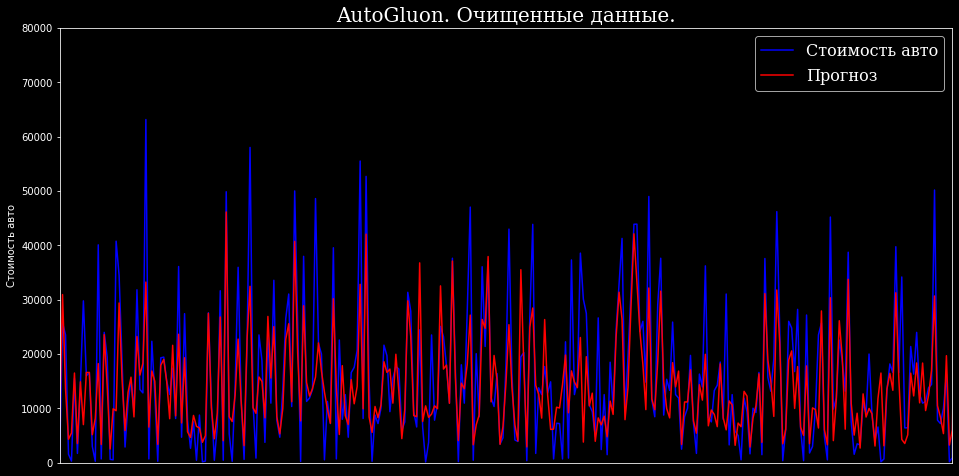

In [ ]:
# plot of target and predict
plt.figure(figsize=(16, 8))
plt.plot(y_new_filt.index, 
         y_new_filt, 
         'b-', label='Стоимость авто')

plt.plot(y_new_filt.index, 
         predict_aut_flt,
         'r-', label='Прогноз')

style = {'family':'serif','size':16}
plt.xlim(1700, 2000)
plt.ylim(0, 80000)
plt.xticks([])

plt.ylabel('Стоимость авто')
plt.legend(prop=style)
plt.title('AutoGluon. Очищенные данные.', fontdict=font);

# Вывод

В данном блокноте содержится практическая работа, в которой:

* Выбран набор данных от Kaggle
* Проведен разведочный анализ
* Очищены данные и убраны выбросы
* Оцифрованы категориальные признаки
* Числовые признаки приведены к одному масштабу
* Подготовлена модель и обучена в следующих библиотеках:
    * Scikit-learn. Random Forest Regressor
    * AutoGluon
* Выполнен тест модели на новых данных.

Составлена сводная таблица по результатам исследования.

In [ ]:
pd.DataFrame({'модель':['Random Forest Regressor', 'AutoGluon. LightGBMXT_BAG_L2'],
              'R2.обучение':[score_rf, score_aut],
              'R2.тест':[score_rf_new, score_aut_new],
              'R2.тест(без выброов)':[score_rf_flt, score_aut_flt],
              'скорость':['быстрая', 'средняя']})

модель  R2.обучение   R2.тест  R2.тест(без выброов)  \
0       Random Forest Regressor     0.704098  0.452922              0.786585   
1  AutoGluon. LightGBMXT_BAG_L2     0.734969  0.416488              0.650093   

  скорость  
0  быстрая  
1  средняя

Предсказание AutoGluon наиболее точные на обучении по метрике R2. Но Случайный лес предсказывает чуть лучше на тесте, к тому же эта модель более простая и быстрее работает. Выберем Случайный лес, как самую оптимальную модель для предсказания стоимости автомобиля.